In [57]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from math import sqrt
from collections import namedtuple
from itertools import count

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("LunarLanderContinuous-v2")

/home/mquan/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Actor

In [144]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, action_dim)
        
        self.max_action = max_action
        
        # weight init
        nn.init.uniform_(self.layer1.weight, -1./sqrt(state_dim), 1./sqrt(state_dim))
        nn.init.uniform_(self.layer2.weight, -1./sqrt(400), 1./sqrt(400))
        nn.init.uniform_(self.layer3.weight, -3*1e-3, 3*1e-3)
        nn.init.uniform_(self.layer1.bias, -1./sqrt(state_dim), 1./sqrt(state_dim))
        nn.init.uniform_(self.layer2.bias, -1./sqrt(400), 1./sqrt(400))
        nn.init.uniform_(self.layer3.bias, -3*1e-3, 3*1e-3)
    
    def forward(self, state):
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        x = torch.tanh(self.layer3(x)) * self.max_action
        return x
        

# Critic
A feedforward network with 2 hiddens layer. 
* 1st layer: 400 units, 2nd layer: 300 units
* Activation: first 2 layer ReLU, last layer: None

Note: Action is included at the input to the first layer

In [145]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, 1)
        
        # weight init
        nn.init.uniform_(self.layer1.weight, -1./sqrt(state_dim + action_dim), 1./sqrt(state_dim + action_dim))
        nn.init.uniform_(self.layer2.weight, -1./sqrt(400), 1./sqrt(400))
        nn.init.uniform_(self.layer3.weight, -3*1e-3, 3*1e-3)
        nn.init.uniform_(self.layer1.bias, -1./sqrt(state_dim + action_dim), 1./sqrt(state_dim + action_dim))
        nn.init.uniform_(self.layer2.bias, -1./sqrt(400), 1./sqrt(400))
        nn.init.uniform_(self.layer3.bias, -3*1e-3, 3*1e-3)
    
    def forward(self, state, action):
        x = F.relu(self.layer1(torch.cat([state, action], dim=1)))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Replay Buffer
Replay Buffer is a list of Transitions. Transitions are named tuples having 4 fields:
* state
* action
* reward
* next state
* done

In [146]:
Transition = namedtuple('Transition', 
                        ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, *args):
        if self.is_full():
            self.memory.pop()
        self.memory.insert(0, Transition(*args))
    
    def is_full(self):
        return len(self.memory) == self.capacity
    
    def sample(self, batch_size):
        transit = random.sample(self.memory, batch_size)
        return Transition(*zip(*transit))

# TD3 class

In [147]:
class TD3(object):
    def __init__(self, state_dim, action_dim, max_action, min_action, capacity,
                 learning_rate=1e-3, batch_size=100, tau=0.005, gamma=0.99):
        self.max_action = max_action
        self.min_action = min_action
        self.gamma = gamma
        self.tau = tau
        # init critic
        self.critic1 = Critic(state_dim, action_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim).to(device)
        
        self.critic1_optim = optim.Adam(self.critic1.parameters(), lr=learning_rate)
        self.critic2_optim = optim.Adam(self.critic2.parameters(), lr=learning_rate)
        
        self.critic1_target = Critic(state_dim, action_dim).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        
        self.critic2_target = Critic(state_dim, action_dim).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # init actor
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=learning_rate)
        
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.replay_buffer = ReplayBuffer(capacity)
        self.batch_size = batch_size
    
    def train(self, update_policy, iteration=1):
        for it in range(iteration):
            # sampe batch of transitions from replay memory
            batch = self.replay_buffer.sample(self.batch_size)
            state = torch.cat(batch.state)
            action = torch.cat(batch.action)
            reward = torch.cat(batch.reward)
            next_state = torch.cat(batch.next_state)
            d = torch.cat(batch.done)
            
            # compute target action
            target_action = self.actor_target(next_state)
            epsilon = np.random.normal(0, 0.2, size=list(target_action.shape)).clip(-0.5, 0.5) # create noise
            target_action += torch.tensor(epsilon, device=device, dtype=torch.float)
            target_action = torch.max(torch.min(target_action, self.max_action), self.min_action)  # clipped
            
            # compute Q_target
            Q_target1 = self.critic1_target(next_state, target_action)
            Q_target2 = self.critic2_target(next_state, target_action)
            td_target = reward + self.gamma * (1 - d) * torch.min(Q_target1, Q_target2).detach()
            
            # update critic 
            critic1_loss = F.mse_loss(self.critic1(state, action), td_target)
            self.critic1_optim.zero_grad()
            critic1_loss.backward(retain_graph=True)
            self.critic1_optim.step()
            
            critic2_loss = F.mse_loss(self.critic2(state, action), td_target)
            self.critic2_optim.zero_grad()
            critic2_loss.backward(retain_graph=True)
            self.critic2_optim.step()
            
            if update_policy:
                actor_loss = -self.critic1(state, self.actor(state)).mean()
                self.actor_optim.zero_grad()
                actor_loss.backward()
                self.actor_optim.step()
                
                # Update target network
                for param, target_param in zip(self.critic1.parameters(), self.critic1_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
                    
                for param, target_param in zip(self.critic2.parameters(), self.critic2_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
                    
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
    def select_action(self, state, add_noise=True):
        assert torch.is_tensor(state)
        # passed the initial acting with random policy phase
        action = self.actor(state)
        if add_noise:
            epsilon = np.random.normal(0, 0.1, size=list(action.shape))
            action += torch.tensor(epsilon, device=device, dtype=torch.float)  # add noise
        action = torch.max(torch.min(action, self.max_action), self.min_action)  # clipped
        return action
        

# Utilities

In [148]:
def to_tensor(np_array):
    '''
    convert 1d np array to tensor (written as a row vector)
    '''
    return torch.FloatTensor(np_array.reshape(1, -1)).to(device)

def checkout_actor(render=False):
    state = env.reset()
    state = to_tensor(state)
    accu_reward = 0
    for step in count():
        action = agent.select_action(state, add_noise=False)
        
        next_state, reward, done, _ = env.step(action.cpu().data.numpy().flatten())
        
        accu_reward += reward
        next_state = to_tensor(next_state)
        
        if render:
            env.render()
            
        if done:
            print("Episode %d [ACTOR] Finish after %d step\tAccumulated reward:%.3f" % (i_episode, step+1, 
                                                                                        accu_reward))
            print("-------------------------------------")
            break
        # Move on 
        state.data.copy_(next_state.data)
    return accu_reward

# Initialize

In [149]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

max_action = torch.tensor(env.action_space.high, device=device, dtype=torch.float)
min_action = torch.tensor(env.action_space.low, device=device, dtype=torch.float)

capacity = int(1e6)

agent = TD3(state_dim, action_dim, max_action, min_action, capacity, batch_size=100, tau=0.001)

max_random_action_steps = 3000
random_action_steps = 0
flag_collecting_exp = True

# statistic
step_per_ep = []
acc_reward_per_ep = []
actor_acc_reward_per_ep = []

## Training loop

In [159]:
max_episode = 51
for i_episode in range(max_episode):
    acc_reward = 0
    obs = env.reset()
    state = to_tensor(obs)
    for step in count():
        # choose action
        if flag_collecting_exp:
            action = to_tensor(env.action_space.sample())
            random_action_steps += 1
        else:
            action = agent.select_action(state)
        
        # observe reward & next state
        next_obs, reward, done, _ = env.step(action.cpu().data.numpy().flatten())
        acc_reward += reward
        
        next_state = to_tensor(next_obs)
        reward = to_tensor(np.array([[reward]]))
        # store transition in replay buffer
        agent.replay_buffer.push(state, action, reward, next_state, to_tensor(np.array([[float(done)]])))
        
        # check if initial random policy phase has passed
        if random_action_steps > max_random_action_steps and flag_collecting_exp:
            flag_collecting_exp = False  # stop random policy
            print("Finish with random policy")
        
        # Update Q-function & policy once random policy is stopped
        if not flag_collecting_exp:
            if step % 2 == 0:
                update_policy = True
            else:
                update_policy = False
            # call the training method
            agent.train(update_policy, iteration=1)
        
        if done:
            if not flag_collecting_exp:
                print("Episode %d finishes after %d step." % (i_episode, step))
                print("-------------------------------------")
            break
            
        # Move on
        state.data.copy_(next_state.data)
    
    if not flag_collecting_exp:
        # store statistic
        step_per_ep.append(step + 1)
        acc_reward_per_ep.append(acc_reward)

        if i_episode % 5 == 0:
            actor_acc_reward_per_ep.append(checkout_actor())
        
        

Episode 0 finishes after 84 step.
-------------------------------------
Episode 0 [ACTOR] Finish after 67 step	Accumulated reward:-376.173
-------------------------------------
Episode 1 finishes after 73 step.
-------------------------------------
Episode 2 finishes after 82 step.
-------------------------------------
Episode 3 finishes after 67 step.
-------------------------------------
Episode 4 finishes after 80 step.
-------------------------------------
Episode 5 finishes after 69 step.
-------------------------------------
Episode 5 [ACTOR] Finish after 79 step	Accumulated reward:-464.165
-------------------------------------
Episode 6 finishes after 78 step.
-------------------------------------
Episode 7 finishes after 60 step.
-------------------------------------
Episode 8 finishes after 58 step.
-------------------------------------
Episode 9 finishes after 75 step.
-------------------------------------
Episode 10 finishes after 76 step.
-----------------------------------

## tau = 0.001
## Action noise clip at = 0.15

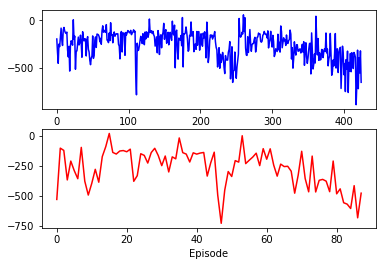

In [160]:
plt.figure(2)
plt.title("Accumulated Reward")
plt.subplot(211)
plt.plot(acc_reward_per_ep, 'b-')
plt.subplot(212)
plt.plot(actor_acc_reward_per_ep, 'r-')
plt.xlabel("Episode")
plt.show()

### Action Noise clipped at 0.5
### tau = 0.001

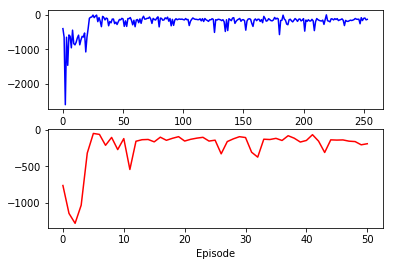

In [81]:
plt.figure(1)
plt.title("Accumulated Reward")
plt.subplot(211)
plt.plot(acc_reward_per_ep, 'b-')
plt.subplot(212)
plt.plot(actor_acc_reward_per_ep, 'r-')
plt.xlabel("Episode")
plt.show()

In [161]:
import time

for i in range(20):
    checkout_actor(True)
    time.sleep(1)
    env.close()

Episode 50 [ACTOR] Finish after 56 step	Accumulated reward:-349.228
-------------------------------------
Episode 50 [ACTOR] Finish after 60 step	Accumulated reward:-516.292
-------------------------------------
Episode 50 [ACTOR] Finish after 84 step	Accumulated reward:-662.262
-------------------------------------
Episode 50 [ACTOR] Finish after 83 step	Accumulated reward:-734.339
-------------------------------------
Episode 50 [ACTOR] Finish after 76 step	Accumulated reward:-775.648
-------------------------------------
Episode 50 [ACTOR] Finish after 85 step	Accumulated reward:-768.938
-------------------------------------
Episode 50 [ACTOR] Finish after 80 step	Accumulated reward:-795.363
-------------------------------------
Episode 50 [ACTOR] Finish after 62 step	Accumulated reward:-579.555
-------------------------------------
Episode 50 [ACTOR] Finish after 57 step	Accumulated reward:-347.614
-------------------------------------
Episode 50 [ACTOR] Finish after 69 step	Accumu

# --------------------------------------------------------

# TESTING AREA

In [45]:
# test replay buffer
rp = ReplayBuffer(10)
s = env.reset()
for i in range(5):
    a = env.action_space.sample()
    n_s, reward, done, _ = env.step(a)
    rp.push(s, a, reward, n_s)
    s = n_s

In [55]:
batch = rp.sample(2)
print(batch.reward)
print(batch.action)


(1.5744464843144739, -0.9941939859433546)
(array([0.9572367 , 0.59831715], dtype=float32), array([-0.76345116,  0.27984205], dtype=float32))


In [99]:
a = torch.tensor(np.array([[0, 5, 4]]).T)
b = torch.tensor(np.array([[1, 6, 2]]).T)
# min_ab, _ = torch.min(torch.cat([a, b], dim=1), dim=1, keepdim=True)
min_ab = torch.min(a, b)

In [102]:
print(min_ab,"\t", min_ab.shape)
print((1 - a) * b)

tensor([[0],
        [5],
        [2]]) 	 torch.Size([3, 1])
tensor([[  1],
        [-24],
        [ -6]])


In [105]:
N = 2
act = np.concatenate([env.action_space.sample().reshape(1,-1) for i in range(N)], axis=0)
act = torch.tensor(act, dtype=torch.float).to(device)
epsilon = np.random.normal(0, 0.2, size=list(act.shape)).clip(-0.5, 0.5)

act += torch.tensor(epsilon, device=device, dtype=torch.float)

low = torch.tensor(env.action_space.low)
high = torch.tensor(env.action_space.high)

clipped = torch.max(torch.min(act, high), low)
print(act)
print("----")
print(clipped)

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #2 'other'

In [89]:
env.action_space.high

array([1., 1.], dtype=float32)

In [90]:
env.action_space.low

array([-1., -1.], dtype=float32)

In [72]:
print(list(act.shape))

[2, 2]


In [95]:
for i_episode in range(1):
    observation = env.reset()
    for t in range(1000):
#         env.render()
#         print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            print("observation:\n", observation)
            break

Episode finished after 130 timesteps
observation:
 [ 0.48910475 -0.22189607  1.5950245  -0.860313   -0.7419953   3.0693738
  1.          0.        ]


In [119]:
float(True)

1.0

In [118]:
float(False)

0.0

In [14]:
a = None
if not a:
    print("true")
else:
    print("fasle")

true


In [19]:
a.any()

AttributeError: 'NoneType' object has no attribute 'any'